In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import train_test_split
from collections import Counter
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# DATASET (HuggingFace)

ds = load_dataset("kannanwisen/Indian-Traffic-Sign-Classification")

full = concatenate_datasets([
    ds["train"]
])

# Split train / val
indices = list(range(len(full)))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    shuffle=True,
    random_state=42,
    stratify=full["label"]  # menjaga distribusi val
)


# TRANSFORM

transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# CUSTOM DATASET

class HFSignsDataset(Dataset):
    def __init__(self, hf_dataset, indices, transform=None):
        self.ds = hf_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        item = self.ds[real_idx]

        image = item["image"]      # PIL
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label).long()

train_dataset = HFSignsDataset(full, train_idx, transform)
val_dataset   = HFSignsDataset(full, val_idx, transform)


# BALANCING (TRAIN ONLY)

train_labels = [full[i]["label"] for i in train_idx]
class_counts = Counter(train_labels)

num_classes = len(class_counts)
num_samples = len(train_labels)

# inverse-frequency weight
class_weights = {
    cls: num_samples / (num_classes * count)
    for cls, count in class_counts.items()
}

sample_weights = torch.DoubleTensor(
    [class_weights[label] for label in train_labels]
)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


# DATALOADER

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=train_sampler
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)

print("Num classes:", num_classes)
print("Class distribution (train):", class_counts)


# MODEL — RESNET50

model = models.resnet50(
    weights=models.ResNet50_Weights.IMAGENET1K_V2
)

# Freeze all
for p in model.parameters():
    p.requires_grad = False

# Unfreeze layer4 + fc
for name, p in model.named_parameters():
    if "layer4" in name or "fc" in name:
        p.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

model = model.to(device)


# LOSS (OPTIONAL: WEIGHTED)

loss_weights = torch.tensor(
    [class_weights[i] for i in range(num_classes)],
    dtype=torch.float
).to(device)

criterion = nn.CrossEntropyLoss(weight=loss_weights)


# OPTIMIZER & SCHEDULER

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=2,
    verbose=True
)


# EARLY STOPPING

best_val_loss = float("inf")
wait = 0
patience = 5
best_model = deepcopy(model.state_dict())

train_loss_history = []
val_loss_history   = []

train_acc_history  = []
val_acc_history    = []


# TRAINING LOOP

EPOCHS = 30

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for phase, loader in [("train", train_loader), ("val", val_loader)]:
        model.train() if phase == "train" else model.eval()

        loss_sum = 0.0
        correct = 0

        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            loss_sum += loss.item() * imgs.size(0)
            correct += (preds == labels).sum().item()

        epoch_loss = loss_sum / len(loader.dataset)
        epoch_acc = correct / len(loader.dataset)
        
        if phase == "train":
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print(f"{phase} | loss: {epoch_loss:.4f} | acc: {epoch_acc:.4f}")

        if phase == "val":
            scheduler.step(epoch_loss)

            if epoch_loss < best_val_loss:
                print("✓ validation improved — saving best model")
                best_val_loss = epoch_loss
                wait = 0
                best_model = deepcopy(model.state_dict())
            else:
                wait += 1
                print(f"No improvement ({wait}/{patience})")

    if wait >= patience:
        print("\nEarly stopping triggered.")
        break


# LOAD BEST MODEL

model.load_state_dict(best_model)


# SAVE MODEL

torch.save(model.state_dict(), "resnet50_roadsigns_balanced.pth")
print("Saved -> resnet50_roadsigns_balanced.pth")



Device: cuda
Num classes: 85
Class distribution (train): Counter({44: 258, 64: 254, 67: 213, 70: 205, 68: 203, 11: 188, 42: 185, 65: 181, 69: 171, 25: 163, 30: 141, 18: 137, 35: 135, 47: 129, 66: 106, 79: 106, 31: 94, 26: 66, 10: 59, 39: 57, 75: 56, 74: 54, 57: 54, 19: 48, 43: 47, 13: 47, 50: 46, 20: 45, 14: 43, 6: 42, 58: 42, 62: 42, 61: 39, 59: 38, 8: 38, 5: 38, 82: 37, 48: 34, 23: 30, 55: 29, 84: 28, 17: 26, 45: 26, 46: 25, 28: 25, 41: 25, 12: 25, 29: 24, 38: 24, 34: 22, 33: 19, 15: 18, 1: 18, 78: 18, 27: 18, 53: 18, 83: 18, 71: 17, 0: 17, 36: 16, 52: 16, 72: 15, 49: 15, 9: 15, 21: 14, 40: 13, 7: 13, 80: 13, 54: 12, 4: 12, 77: 11, 32: 11, 60: 11, 37: 10, 56: 9, 3: 8, 73: 8, 63: 8, 51: 7, 2: 7, 76: 6, 16: 6, 22: 6, 81: 5, 24: 2})


c:\Users\Deniel\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/30
train | loss: 2.1463 | acc: 0.2463
val | loss: 2.3826 | acc: 0.1789
✓ validation improved — saving best model

Epoch 2/30
train | loss: 0.6982 | acc: 0.5932
val | loss: 1.3396 | acc: 0.4258
✓ validation improved — saving best model

Epoch 3/30
train | loss: 0.3673 | acc: 0.7408
val | loss: 0.9554 | acc: 0.5925
✓ validation improved — saving best model

Epoch 4/30
train | loss: 0.2085 | acc: 0.8127
val | loss: 0.9805 | acc: 0.6719
No improvement (1/5)

Epoch 5/30
train | loss: 0.1544 | acc: 0.8587
val | loss: 1.1639 | acc: 0.7077
No improvement (2/5)

Epoch 6/30
train | loss: 0.1297 | acc: 0.8873
val | loss: 0.7401 | acc: 0.7984
✓ validation improved — saving best model

Epoch 7/30
train | loss: 0.1354 | acc: 0.8862
val | loss: 0.7256 | acc: 0.7775
✓ validation improved — saving best model

Epoch 8/30
train | loss: 0.1139 | acc: 0.9033
val | loss: 0.8296 | acc: 0.7216
No improvement (1/5)

Epoch 9/30
train | loss: 0.0530 | acc: 0.9273
val | loss: 0.8970 | acc: 0.7967
No impr

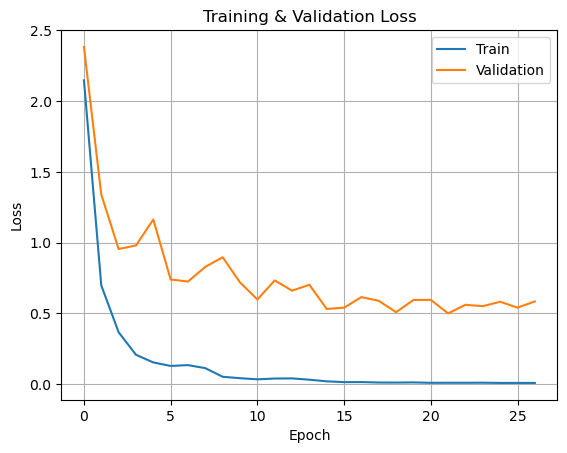

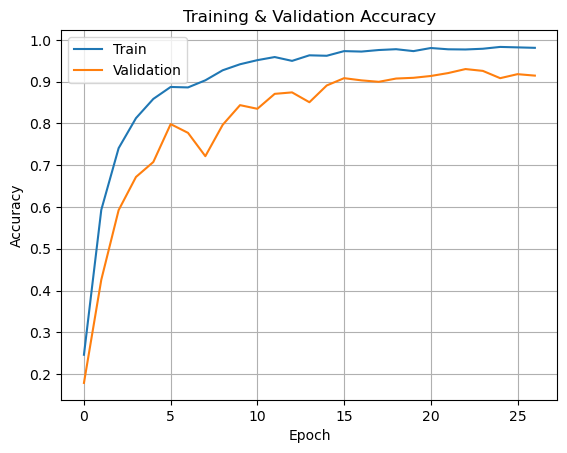

In [7]:
import matplotlib.pyplot as plt


# =========================
# PLOT LOSS
# =========================
plt.figure()
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.grid(True)
plt.show()

# =========================
# PLOT ACCURACY
# =========================
plt.figure()
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)
plt.show()